In [1]:
import os 
os.chdir("D:/Myprojects/credit risk detection system")

In [2]:
#Importing required libraries
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.preprocessing import StandardScaler,OneHotEncoder,LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline
from sklearn.metrics import classification_report ,accuracy_score,confusion_matrix,roc_auc_score
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import joblib

In [3]:

#Data collection and Inspection 
df  = pd.read_csv("credit_risk_30k_realistic.csv")
print(df.info())
print(df.head())
print(df.columns)
print(df['Default'].value_counts())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                30000 non-null  int64  
 1   Gender             30000 non-null  object 
 2   EmploymentYears    30000 non-null  int64  
 3   HomeOwnership      30000 non-null  object 
 4   MaritalStatus      30000 non-null  object 
 5   AnnualIncome       30000 non-null  int64  
 6   LoanAmount         30000 non-null  int64  
 7   LoanTermMonths     30000 non-null  int64  
 8   CreditScore        30000 non-null  int64  
 9   NumCreditCards     30000 non-null  int64  
 10  DebtToIncomeRatio  30000 non-null  float64
 11  PreviousDefaults   30000 non-null  int64  
 12  Default            30000 non-null  int64  
dtypes: float64(1), int64(9), object(3)
memory usage: 3.0+ MB
None
   Age  Gender  EmploymentYears HomeOwnership MaritalStatus  AnnualIncome  \
0   59  Female             

In [4]:
#Data preprocessing 
print(df.isnull().sum())

Age                  0
Gender               0
EmploymentYears      0
HomeOwnership        0
MaritalStatus        0
AnnualIncome         0
LoanAmount           0
LoanTermMonths       0
CreditScore          0
NumCreditCards       0
DebtToIncomeRatio    0
PreviousDefaults     0
Default              0
dtype: int64


                Age  EmploymentYears  AnnualIncome    LoanAmount  \
count  30000.000000     30000.000000  3.000000e+04  3.000000e+04   
mean      44.998833        20.683467  7.101374e+05  3.552143e+05   
std       14.123246        13.913974  2.519721e+05  1.806113e+05   
min       21.000000         0.000000  1.500000e+05  3.022400e+04   
25%       33.000000         8.000000  5.178855e+05  2.144350e+05   
50%       45.000000        20.000000  6.947305e+05  3.231770e+05   
75%       57.000000        33.000000  8.896005e+05  4.659925e+05   
max       69.000000        45.000000  1.675105e+06  1.172121e+06   

       LoanTermMonths   CreditScore  NumCreditCards  DebtToIncomeRatio  \
count    30000.000000  30000.000000    30000.000000       30000.000000   
mean        37.208000    690.583567        2.990833           0.500847   
std         14.213355     48.609853        1.721080           0.173615   
min         12.000000    501.000000        0.000000           0.200000   
25%         24.00

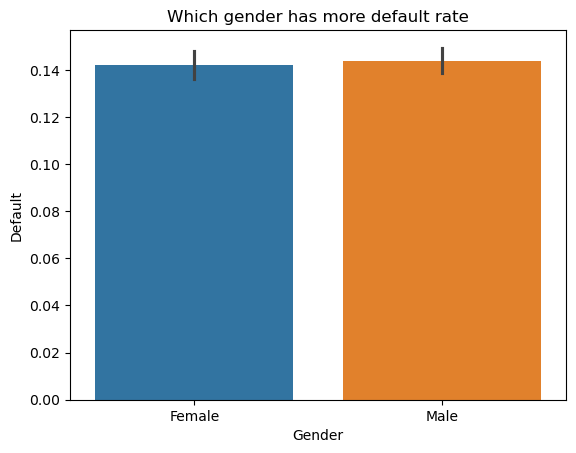

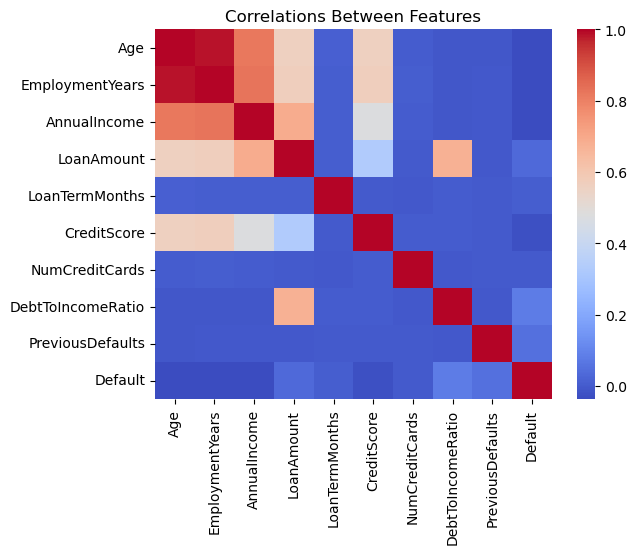

In [5]:
#Exploartory data analysis
print(df.describe())
#which one gender has more credit deafult
sns.barplot(x= 'Gender',y= 'Default' ,data  = df,hue= 'Gender')
plt.title("Which gender has more default rate")
plt.show()
#correlations between numerical features
corr  = df.corr(numeric_only = True)
sns.heatmap(corr,cmap='coolwarm')
plt.title("Correlations Between Features")
plt.show()

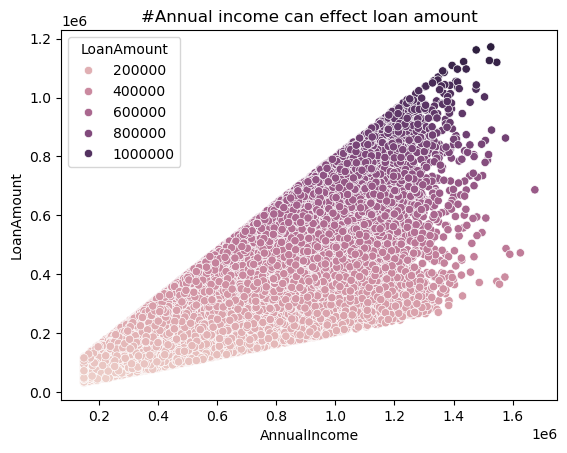

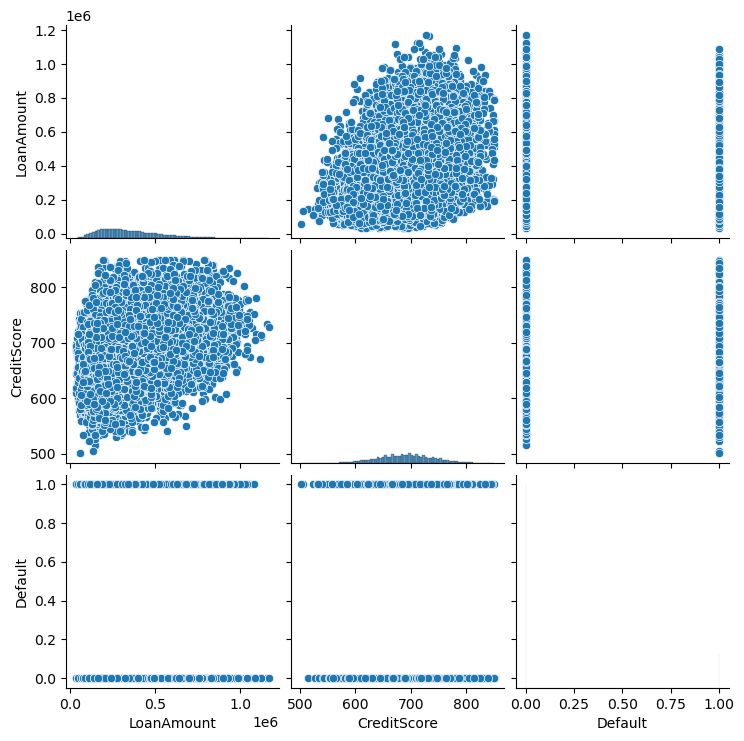

In [6]:
#Annual income can effect loan amount
sns.scatterplot(x='AnnualIncome',y= 'LoanAmount',data  = df,hue='LoanAmount')
plt.title("#Annual income can effect loan amount")
plt.show()
#pairplot for multivariate analysis
sns.pairplot(df[['LoanAmount','CreditScore','Default']])
plt.show()

In [7]:
df.columns


Index(['Age', 'Gender', 'EmploymentYears', 'HomeOwnership', 'MaritalStatus',
       'AnnualIncome', 'LoanAmount', 'LoanTermMonths', 'CreditScore',
       'NumCreditCards', 'DebtToIncomeRatio', 'PreviousDefaults', 'Default'],
      dtype='object')

In [8]:
#feature engineering
X  = df[['Age','Gender','AnnualIncome','EmploymentYears','LoanAmount','CreditScore',"LoanTermMonths"]]
y = df['Default']

#train_test_split 
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size  = 0.2,random_state = 42)

#define data types for pipeline 
num = X_train.select_dtypes(include=['int64','float64']).columns
cat = X_train.select_dtypes(include=['object']).columns

#standing scaling and categorical data encoding
preprocessor  = ColumnTransformer([
    ('categorical_data',OneHotEncoder(handle_unknown='ignore'),cat),
    ('numerical_data',StandardScaler(),num),
   
])

#modeling 
#model selection
rfc_model = RandomForestClassifier(class_weight= 'balanced',random_state = 42)
#pipeline 
pipeline  = Pipeline( steps= [
    ('preprocessing',preprocessor),
        ('smoting',SMOTE()),

        ('model',rfc_model)
])

#model training
pipeline.fit(X_train,y_train)

#prediction 
y_pred  = pipeline.predict(X_test)
print("Credit Default prediction",pipeline.predict_proba(X_test).mean())

#model evaluation 
print("Model accuracy score:",accuracy_score(y_test,y_pred))
print("Confusion_matrix:",confusion_matrix(y_test,y_pred))
print("Classfication_matrix:",classification_report (y_test,y_pred))
a= roc_auc_score (y_test,y_pred)
print(f"roc_accuracy_score{a:.4f}")

Credit Default prediction 0.5
Model accuracy score: 0.7996666666666666
Confusion_matrix: [[4714  407]
 [ 795   84]]
Classfication_matrix:               precision    recall  f1-score   support

           0       0.86      0.92      0.89      5121
           1       0.17      0.10      0.12       879

    accuracy                           0.80      6000
   macro avg       0.51      0.51      0.50      6000
weighted avg       0.76      0.80      0.77      6000

roc_accuracy_score0.5080


In [9]:
#Defsult prediction for new cusotmer data 
new_data = {"Age":30,"Gender":"Male","AnnualIncome":300000,"LoanAmount":600000,"EmploymentYears":25,"CreditScore":600,'LoanTermMonths':20}
new_data  = pd.DataFrame([new_data])
prob_new_data = pipeline.predict(new_data)
prob_new_data
#saving model
joblib.dump(pipeline,'developedmodel.pk1')

['developedmodel.pk1']

In [10]:
#Feature Importances
feature  = pipeline.named_steps['preprocessing'].get_feature_names_out()
importance  = pipeline.named_steps['model'].feature_importances_
DF  = pd.DataFrame({'features':feature,
                             'importances':importance,
})
print(DF)

                          features  importances
0  categorical_data__Gender_Female     0.008622
1    categorical_data__Gender_Male     0.008729
2              numerical_data__Age     0.198481
3     numerical_data__AnnualIncome     0.179839
4  numerical_data__EmploymentYears     0.184368
5       numerical_data__LoanAmount     0.180561
6      numerical_data__CreditScore     0.181265
7   numerical_data__LoanTermMonths     0.058134


In [11]:
#cross value score 
cross_validation  = cross_val_score(pipeline,X,y,cv= 5)
print("Cross Validation Score:",cross_validation.mean())


Cross Validation Score: 0.8036999999999999


In [ ]:
#sahpe values
import shap 
model  = pipeline.named_steps["model"]
X_transformed = pipeline.named_steps['preprocessing'].transform(X)
explainer   = shap.TreeExplainer(model)
values  = explainer .shap_values(X_transformed )
shap.summary_plot(values,X_transformed)
X.columns